In [ ]:
# Use Google Colab
use_colab = True
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/685'

    !pip install -r requirements.txt

!pip install sentencepiece

from datasets import load_dataset

import sys
import os
import random
import shutil
import copy
import inspect


import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm


Dataset preproccesing script


In [ ]:
import pandas as pd

# text_df_a = pd.read_csv("./OLIDv1/testset-levela.tsv", sep="\t")
# labels_df_a = pd.read_csv("./OLIDv1/labels-levela.csv", sep=",")
# merged_df_a = pd.merge(text_df_a, labels_df_a, on='id', how='outer')
# merged_df_a.to_csv("olid_test_subtask_a.csv",sep="\t",index=False)

# text_df_b = pd.read_csv("./OLIDv1/testset-levelb.tsv", sep="\t")
# labels_df_b = pd.read_csv("./OLIDv1/labels-levelb.csv", sep=",")
# merged_df_b = pd.merge(text_df_b, labels_df_b, on='id', how='outer')
# merged_df_b.to_csv("olid_test_subtask_b.csv",sep="\t",index=False)

# text_df_c = pd.read_csv("./OLIDv1/testset-levelc.tsv", sep="\t")
# labels_df_c = pd.read_csv("./OLIDv1/labels-levelc.csv", sep=",")
# merged_df_c = pd.merge(text_df_c, labels_df_c, on='id', how='outer')
# merged_df_c.to_csv("olid_test_subtask_c.csv",sep="\t",index=False)


# train_df = pd.read_csv("./OLIDv1/olid-training-v1.0.tsv", sep="\t").fillna('not present')
# train_df.to_csv("olid_train_v2.csv",sep="\t",index=False)

In [ ]:
from datasets import load_dataset


from datasets import load_dataset
test_a_dataset = load_dataset('csv', data_files={'test': 'olid_test_subtask_a.csv'}, delimiter="\t", cache_dir='./olid_cache')
test_b_dataset = load_dataset('csv', data_files={'test': 'olid_test_subtask_b.csv'}, delimiter="\t", cache_dir='./olid_cache')
test_c_dataset = load_dataset('csv', data_files={'test': 'olid_test_subtask_c.csv'}, delimiter="\t", cache_dir='./olid_cache')

train_dataset = load_dataset('csv', data_files={'train': 'olid_train_v2.csv','valid': 'olid_val_v2.csv'}, delimiter="\t", cache_dir='./olid_cache')

In [3]:
import torch

import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
set_seed(685)

tokenizer = T5Tokenizer.from_pretrained('t5-small', cache_dir='./t5_cache')
model = T5ForConditionalGeneration.from_pretrained('t5-small', cache_dir='./t5_cache')

train_dataloader = torch.utils.data.DataLoader(train_dataset['train'].select(range(1024)), shuffle=True, batch_size=20)
val_dataloader = torch.utils.data.DataLoader(train_dataset['valid'], shuffle=True, batch_size=8)


# the following 2 hyperparameters are task-specific
max_source_length = 512
max_target_length = 12
training_epochs = 5

In [ ]:
for i in train_dataset['train']:
  print(i)
  break

{'id': 86426, 'tweet': '@USER She should ask a few native Americans what their take on this is.', 'subtask_a': 'OFF', 'subtask_b': 'UNT', 'subtask_c': 'not present'}


In [ ]:
# optimizer
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-4, eps=1e-8)

In [5]:
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")
print(device)

Found device: Tesla K80, n_gpu: 1
cuda


In [ ]:
#model.load_state_dict(torch.load(os.path.join('./olid_trained_models/', 't5_full_shot_epoch_1.pt')))
model.cuda()
training_epochs = 5
start_epoch = 1
for epoch in tqdm.notebook.tqdm(range(start_epoch,training_epochs)):
  print("Training epoch %d" % epoch)
  print()
  model.train()

  for batch in tqdm.notebook.tqdm(train_dataloader):
    # text = batch['text']
    input_sequences=[]
    output_sequences = []
    for idx, text in enumerate(batch['tweet']):
      if batch['subtask_a'][idx] == "NOT":
        input_sequences.append(text + '<\s> ' + 'Offensive speech is ')
        output_sequences.append("not present.")
      else:
        input_sequences.append(text + '<\s> ' + 'Offensive speech is ')
        output_sequences.append("present.")
        if batch['subtask_b'][idx] == "UNT":
          input_sequences.append(text + '<\s> ' + 'Targeted offensive speech is ')
          output_sequences.append("not present.")
        else:
          input_sequences.append(text + '<\s> ' + 'Targeted offensive speech is ')
          output_sequences.append("present.")
          if batch['subtask_c'][idx] == "IND":
            input_sequences.append(text + '<\s> ' + 'Targeted speech towards individual is ')
            output_sequences.append("present.")
            input_sequences.append(text + '<\s> ' + 'Targeted speech towards group is ')
            output_sequences.append("not present.")
          elif batch['subtask_c'][idx] == "GPR":
            input_sequences.append(text + '<\s> ' + 'Targeted speech towards individual is ')
            output_sequences.append("not present.")
            input_sequences.append(text + '<\s> ' + 'Targeted speech towards group is ')
            output_sequences.append("present.")
          else:
            input_sequences.append(text + '<\s> ' + 'Targeted speech towards individual is ')
            output_sequences.append("not present.")
            input_sequences.append(text + '<\s> ' + 'Targeted speech towards group is ')
            output_sequences.append("not present.")

    # encode the inputs
    
    encoding = tokenizer(input_sequences,
                        padding='longest',
                        max_length=max_source_length,
                        truncation=True,
                        return_tensors="pt")
    input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

    # encode the targets
    target_encoding = tokenizer(output_sequences,
                                padding='longest',
                                max_length=max_target_length,
                                truncation=True)
    labels = target_encoding.input_ids

    # replace padding token id's of the labels by -100
    labels = [
              [(label if label != tokenizer.pad_token_id else -100) for label in labels_example] for labels_example in labels
    ]
    input_ids=input_ids.to(device)
    attention_mask=attention_mask.to(device)
    labels=torch.as_tensor(labels).to(device)
    # forward pass
    loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  torch.save(model.state_dict(),os.path.join('./olid_trained_models_v2/', 't5_full_shot_epoch_{}.pt'.format(epoch)))

  0%|          | 0/4 [00:00<?, ?it/s]

Training epoch 1



  0%|          | 0/662 [00:00<?, ?it/s]

Training epoch 2



  0%|          | 0/662 [00:00<?, ?it/s]

Training epoch 3



  0%|          | 0/662 [00:00<?, ?it/s]

Training epoch 4



  0%|          | 0/662 [00:00<?, ?it/s]

subtask_a evaluation

In [14]:
test_dataloader = torch.utils.data.DataLoader(test_a_dataset['test'], batch_size=32)
y_pred = []
y_true = []
with torch.no_grad():
  model.load_state_dict(torch.load(os.path.join('./olid_trained_models_v2/', 't5_full_shot_epoch_4.pt')))
  model.eval()
  model.cuda()
  count_1 = 0
  count_2 = 0
  for batch in tqdm.notebook.tqdm(test_dataloader):
    # when generating, we will use the logits of right-most token to predict the next token
    # so the padding should be on the left
    tokenizer = T5Tokenizer.from_pretrained('t5-small', cache_dir='./t5_cache')
    sentences = batch['tweet'] # use different length sentences to test batching
    sentences = [sentence + '<\s> ' + 'Offensive speech is ' for sentence in sentences]
    #print(sentences)
    inputs = tokenizer(sentences, return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=inputs['input_ids'].to(device),
        attention_mask=inputs['attention_mask'].to(device),
        max_length=12,
        early_stopping=True,
        num_beams=10,
        num_return_sequences=1,
        no_repeat_ngram_size=2
    )
    batch_preds = (tokenizer.batch_decode(output_sequences, skip_special_tokens=True,clean_up_tokenization_spaces=True))
    for i,pred in enumerate(batch_preds):
      if "present." == pred:
        y_pred.append('OFF')
      else:
        y_pred.append('NOT')
    y_true.extend(batch['label'])

from sklearn.metrics import classification_report
report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

  0%|          | 0/27 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         NOT       0.89      0.83      0.86       620
         OFF       0.63      0.72      0.67       240

    accuracy                           0.80       860
   macro avg       0.76      0.78      0.77       860
weighted avg       0.81      0.80      0.81       860



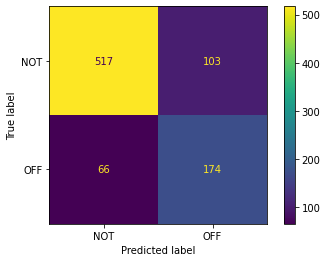

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NOT','OFF'])
disp.plot()
plt.show()

In [19]:
test_dataloader = torch.utils.data.DataLoader(test_b_dataset['test'], batch_size=32)
y_pred = []
y_true = []
with torch.no_grad():
  model.cuda()
  model.eval()
  count_1 = 0
  count_2 = 0
  for batch in tqdm.notebook.tqdm(test_dataloader):
    # when generating, we will use the logits of right-most token to predict the next token
    # so the padding should be on the left
    tokenizer = T5Tokenizer.from_pretrained('t5-small', cache_dir='./t5_cache')
    sentences = batch['tweet'] # use different length sentences to test batching
    sentences = [sentence + '<\s> ' + 'Targeted offensive speech is ' for sentence in sentences]
    inputs = tokenizer(sentences, return_tensors="pt", padding=True)
    output_sequences = model.generate(
        input_ids=inputs['input_ids'].to(device),
        attention_mask=inputs['attention_mask'].to(device),
        max_length=13,
        early_stopping=True,
        num_beams=10,
        num_return_sequences=1,
        no_repeat_ngram_size=2
    )
    batch_preds = (tokenizer.batch_decode(output_sequences, skip_special_tokens=True,clean_up_tokenization_spaces=True))
    for i,pred in enumerate(batch_preds):
      if "present." == pred:
        y_pred.append('TIN')
      else:
        y_pred.append('UNT')
    y_true.extend(batch['label'])

from sklearn.metrics import classification_report
report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

  0%|          | 0/8 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         TIN       0.91      1.00      0.95       213
         UNT       0.86      0.22      0.35        27

    accuracy                           0.91       240
   macro avg       0.88      0.61      0.65       240
weighted avg       0.90      0.91      0.88       240



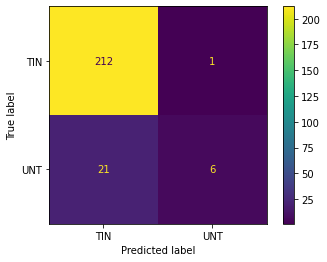

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['TIN','UNT'])
disp.plot()
plt.show()

In [22]:
test_dataloader = torch.utils.data.DataLoader(test_c_dataset['test'], batch_size=32)
y_pred = []
y_true = []
with torch.no_grad():
  model.load_state_dict(torch.load(os.path.join('./olid_trained_models/', 't5_full_shot_epoch_4.pt')))
  model.cuda()
  model.eval()
  for batch in tqdm.notebook.tqdm(test_dataloader):
    tokenizer = T5Tokenizer.from_pretrained('t5-small', cache_dir='./t5_cache')
    sentences = batch['tweet'] # use different length sentences to test batching
    sentences_i = [sentence + '<\s> ' + 'Targeted speech towards individual is ' for sentence in sentences]
    sentences_g = [sentence + '<\s> ' + 'Targeted speech towards group is ' for sentence in sentences]
    inputs_i = tokenizer(sentences_i, return_tensors="pt", padding=True)
    inputs_g = tokenizer(sentences_g, return_tensors="pt", padding=True)
    output_sequences_i = model.generate(
        input_ids=inputs_i['input_ids'].to(device),
        attention_mask=inputs_i['attention_mask'].to(device),
        max_length=13,
        early_stopping=True,
        num_beams=10,
        num_return_sequences=1,
        no_repeat_ngram_size=2
    )
    output_sequences_g = model.generate(
        input_ids=inputs_g['input_ids'].to(device),
        attention_mask=inputs_g['attention_mask'].to(device),
        max_length=13,
        early_stopping=True,
        num_beams=10,
        num_return_sequences=1,
        no_repeat_ngram_size=2
    )
    preds_i = (tokenizer.batch_decode(output_sequences_i, skip_special_tokens=True,clean_up_tokenization_spaces=True))
    preds_g = (tokenizer.batch_decode(output_sequences_g, skip_special_tokens=True,clean_up_tokenization_spaces=True))
    for i,pred in enumerate(preds_i):
      if "present." == preds_i[i] and "not present." == preds_g[i]:
        y_pred.append('IND')
      elif "present." == preds_g[i] and "not present." == preds_i[i]:
        y_pred.append('GRP')
      else:
        y_pred.append('OTH')
    y_true.extend(batch['label'])

from sklearn.metrics import classification_report
report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         GRP       0.00      0.00      0.00        78
         IND       1.00      0.02      0.04       100
         OTH       0.16      0.97      0.28        35

    accuracy                           0.17       213
   macro avg       0.39      0.33      0.11       213
weighted avg       0.50      0.17      0.06       213



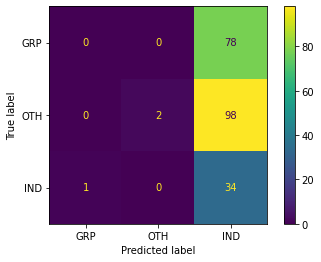

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['GRP','OTH','IND'])
disp.plot()
plt.show()